# Assignment 3 - Gaussian processes regression (for creating magnetic field maps)

- **Topic:** Understanding regression with Gaussian processes

- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:**  21-03-2025, 17:00
- **Submitting: SUBMIT ONLY `assignment3_groupNumber.ipynb` TO BRIGHTSPACE**. 
where groupNumber is your groupnumber


## Instructions
**Installation:** The implementation is tested with python 3.9.12 and packages including
-   numpy version: 1.26.4
-   scipy version: 1.13.0
-   matplotlib version: 3.5.1


Other (not too old or new) versions will probably also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `GP.py`, `helper.py` and `linAlg.py` and the dictionary `modelParameters` as this might result in breaking the assignment.



## AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.


## Information
Please fill in your group number, names and student numbers in the cell below.



In [1]:
''' YOUR ANSWER HERE '''
groupNumber = 10

STUDENT_1_NAME = "Niklas Knöll"
STUDENT_1_STUDENT_NUMBER = "5006961"

STUDENT_2_NAME = "Jefferson Yeh"
STUDENT_2_STUDENT_NUMBER = "5296005"

# raise NotImplementedError()


''' DO NOT CHANGE THE CODE BELOW '''
import numpy as np
import matplotlib.pyplot as plt
import GP as GP
import helper as helper
import linAlg as linAlg
import scipy.optimize as opt

np.random.seed(groupNumber)

## Objectives

#### Goal

The final goal of this assignment is to create a map of the magnetic field, similar to the one used in the previous two assignments. In order to achieve this, you will first come to understand the basics of Gaussian process (GP) regression. In this assignment, you may assume that all the positions $ \mathbf{p}_t $ of an agent, for $t = {1, ..., \text{T}}$ time-steps, are known. In other words, the dynamic model and the initial position from the previous assignments are known exactly. Instead, you will learn a GP model $f(\cdot)$ to model the magnetic field using the non-linear measurement model:
$$ y_t = f(\mathbf{p}_t) + v_t $$

Where:
- $f(\cdot) \sim \mathcal{GP}(0, \kappa(\mathbf{p}, \mathbf{p}'))$ 

- $\kappa(\mathbf{p}, \mathbf{p}')$ is a kernel function, which takes two positions as inputs, and outputs a scalar.

- $y_t$ is a scalar measurement of the magnetic field at time-step $t$.

- $f(\cdot)$ is the reduced rank Gaussian process function.

- $v_t \sim \mathcal{N}(0, R)$ is Gaussian white noise.

- $R \in \mathbb{R}^{1 \times 1} $ is the covariance of the measurement noise.


#### First create the squared exponential kernel
Maybe the most common choice for kernels in GP regression is the squared exponential kernel. The kernel is defined as
$$ \kappa_{\text{se}}(\mathbf{p}, \mathbf{p}') = \sigma^2_{\text{f}} \text{exp} \left(\frac{||\mathbf{p}-\mathbf{p}'||^2}{-2 \ell^2} \right),$$
where we have an arbitrary vector $\mathbf{p} \in \mathbb{R}^D$, with $D$ any positive integer. We have also introduced two new variables

- The length-scale $\ell$

- The signal variance $\sigma^2_{\text{f}}$

#### Task:

Based on the given definition of the squared exponential kernel, fill in the function `kernelSE` below. 


#### Analysis:

Elaborate on the following:

- What does a high or low kernel value represent?

- What changes when you change the value of the length-scale and the signal variance?  


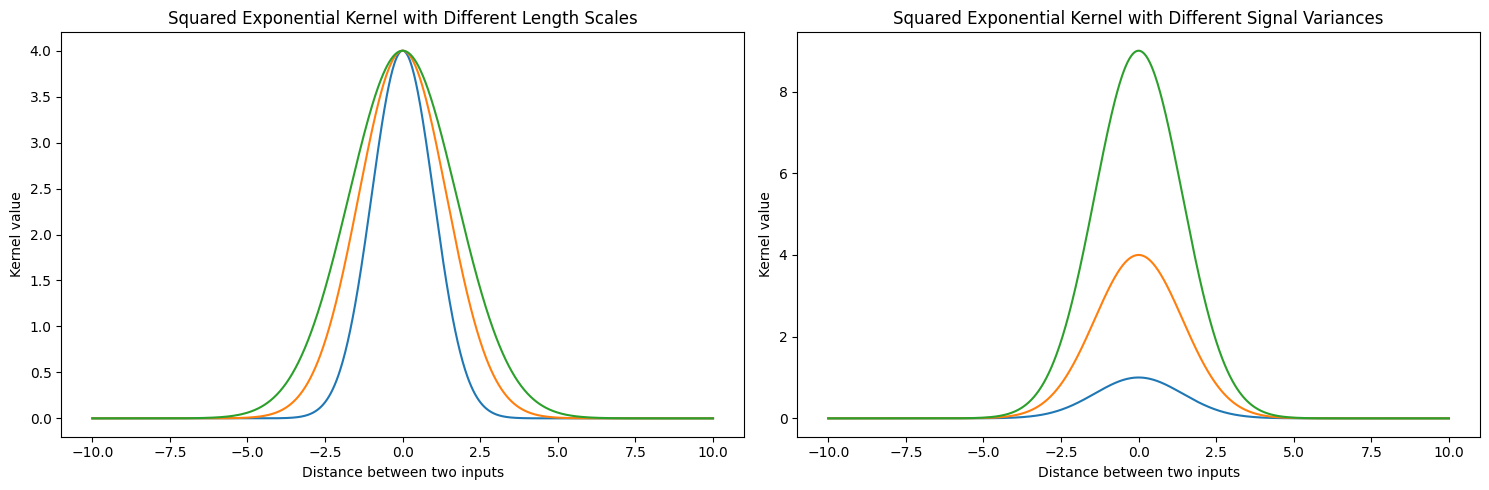

In [6]:
def kernelSE(x1, x2, lengthScaleSquared, signalVarianceSE):
    k = signalVarianceSE*signalVarianceSE * np.exp(np.abs(x1-x2)**2/(-2*lengthScaleSquared))
    return k

lengthScales = np.array([1, 2, 3])
signalVarianceSEs = np.array([1, 2, 3])



''' Code for plotting: Do not change code below '''
steps = 1000
p0 = np.zeros((1, 1))
PLine = np.linspace(-10, 10, steps).reshape(1, -1)

kValues = np.zeros((steps, 6))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for indx, lengthScaleSquared in enumerate(lengthScales):
    kValues[:, indx] = kernelSE(p0, PLine, lengthScaleSquared, signalVarianceSEs[1])
    axs[0].plot(PLine[0, :], kValues[:, indx])

for indx, signalVariancePeriod in enumerate(signalVarianceSEs):
    kValues[:, indx + 3] = kernelSE(p0, PLine, lengthScales[1], signalVariancePeriod)
    axs[1].plot(PLine[0, :], kValues[:, indx + 3])

axs[0].set_title("Squared Exponential Kernel with Different Length Scales")
axs[0].set_xlabel("Distance between two inputs")
axs[0].set_ylabel("Kernel value")
axs[1].set_title("Squared Exponential Kernel with Different Signal Variances")
axs[1].set_xlabel("Distance between two inputs")
axs[1].set_ylabel("Kernel value")

plt.tight_layout()
plt.show()


#### Sampling from a Gaussian process prior
Sampling from a Gaussian process can be useful, for e.g. creating artificial datasets. Let us continue with the squared exponential kernel (although this extends to all valid kernels). Using this kernel, we can make a kernel matrix as

$$
\mathbf{K}_{\text{se}}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) = 
\begin{bmatrix} \kappa_{\text{se}}(\mathbf{p}_{1}, \mathbf{p}_{\text{1}})  & \dots & \kappa_{\text{se}}(\mathbf{p}_{1}, \mathbf{p}_{\text{T}}) \\
\vdots & \ddots & \vdots \\
\kappa_{\text{se}}(\mathbf{p}_{\text{T}}, \mathbf{p}_{1}) & \dots & \kappa_{\text{se}}(\mathbf{p}_{\text{T}}, \mathbf{p}_{\text{T}})
\end{bmatrix}
$$

The prior covariance kernel for all prediction locations $\mathbf{P}_{\star}$ then becomes

$$
\begin{aligned}
\mathbf{f}_{\star} &\sim \mathcal{N}\left(0, \mathbf{K}(\mathbf{P}_{\star},\mathbf{P}_{\star})\right), \\
 &\sim \mathcal{N}\left(0, \mathbf{L} \mathbf{L}^{\text{T}}\right) 
\end{aligned}
$$

Where $\mathbf{L}$ denotes the (lower triangular) cholesky decomposition

$$
\mathbf{f}_{\star} = \mathbf{L}\mathbf{z}, \quad \mathbf{z} \sim \mathcal{N}\left(0, \mathbf{I} \right)  \\
$$

For more details see e.g. (https://gaussianprocess.org/gpml/)

#### Task:

Using the Cholesky decomposition, fill in the function `samplingFromPrior`, such that you can sample `Nsamples` function evaluations from a GP prior with the squared exponential kernel.



#### Analysis:

Elaborate on what happens in the plot when you change the values of the two parameters

- lengthScaleSquared
- signalVarianceSE


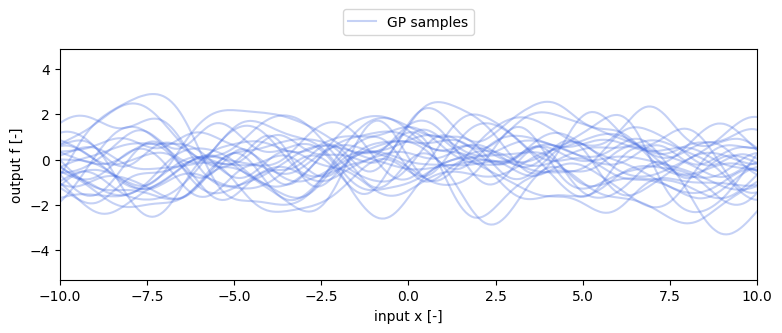

In [56]:

def kernelMatrixSE(X1, X2, lengthScaleSquared, signalVarianceSE):
    K = kernelSE(X1, X2, lengthScaleSquared, signalVarianceSE)

    # D1 = X1.size
    # D2 = X2.size
    # K = np.zeros((D1, D2))
    
    # for i in range(D1):
    #     for j in range(D2):
    #         K[i, j] = kernelSE(X1[:, i], X2[:,j], lengthScaleSquared, signalVarianceSE)

    return K

def samplingFromPrior(Xprior, lengthScaleSquared, signalVariance):
    D = Xprior.size

    K = kernelMatrixSE(Xprior, Xprior.T, lengthScaleSquared, signalVariance)
    L = np.linalg.cholesky(K + np.eye(D)*10**-6)
    z = np.random.multivariate_normal(np.zeros(D), np.eye(D))

    fPrior = L @ z 
    return fPrior.reshape(-1, 1)

lengthScaleSquared = 1
signalVariancePeriod = 1


''' Code for plotting: Do not change'''
posPred1D = np.linspace(-10, 10, 250).reshape(1, -1)

Nsamples = 25
fPriorSamples = np.zeros((Nsamples, 250))
fPosteriorSamples = np.zeros((Nsamples, 250))
for samplendx in range(Nsamples):
    # print(posPred1D.shape)
    fPriorSamples[samplendx, :] = samplingFromPrior(posPred1D, lengthScaleSquared, signalVariancePeriod).ravel()

helper.makeGaussianProcessSamplingPlots(posPred1D, fPriorSamples)


#### Gaussian process predictions

Previously, we considered the case where our data has no measurement noise. Below we show the derivation for the case when we have noisy data, which leads to joint distribution

$$
\begin{bmatrix}
\mathbf{y}_{1:\text{T}} \\
\mathbf{f}_{\star}
\end{bmatrix}
\sim \mathcal{N}\left(
\mathbf{0},
\begin{bmatrix}
\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) + \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} & \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}) \\
\mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) & \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star})
\end{bmatrix}
\right)
$$

The joint distribution leads to the predictive mean and covariance as

$$
\begin{aligned} \mathbb{E}[f(\mathbf{p}_{\star})] &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \left(\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) +  \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} \right)^{-1}\mathbf{y}_{1:\text{T}}, \\
\mathbb{V}[f(\mathbf{p}_{\star})] &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \left(\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) +  \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} \right)^{-1} \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}) 
\end{aligned}$$

However, in practice, the inversion can be numerically unstable, to improve stability we use the Cholesky decomposition from \cite{}: 

$$ 
\begin{aligned} \mathbf{L} &:= \text{chol}\left( \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) +  \sigma^2_{\text{y}} \mathbf{I}_{\text{T}} \right), \\
\mathbf{a} &:= (\mathbf{L}^{\text{T}})^{-1} \left(\mathbf{L}^{-1} \mathbf{y}_{1:\text{T}} \right), \\
\mathbf{v} &:= \mathbf{L}^{-1} \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}), \\
\mathbb{E}[f(\mathbf{p}_{\star})] &:= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \mathbf{a}, \\
\mathbb{V}[f(\mathbf{p}_{\star})] &:= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star}) - \mathbf{v}^{\text{T}} \mathbf{v}  
\end{aligned}$$

#### Task:

- Finish the implementation of `predictSE`, such that you can predict the mean and covariance of the posterior GP, at given test locations $\mathbf{P}_{\star}$.

- By hand, tune the hyper-parameters `lengthScaleSquared`, `signalVarianceSE` `noiseVariance`, to make predictions on the give dataset.

#### Analysis:

Elaborate on the quality of the prediction on the left half of the figure and the right half of the figure. 
- How well does it predict the latent function?

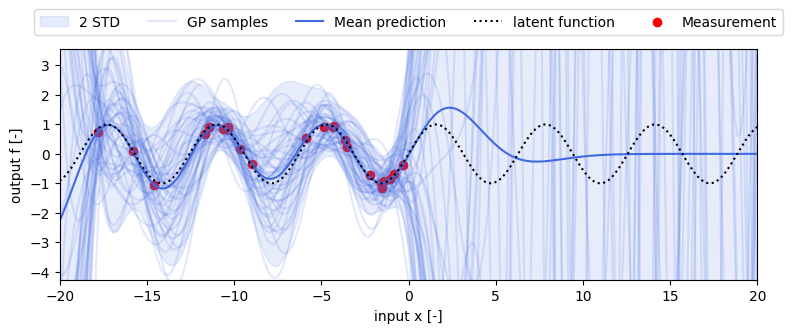

In [82]:
def predictSE(Xstar, X, y, lengthScaleSquared, signalVarianceSE, noiseVariance):

    Kxx = kernelMatrixSE(X, X.T, lengthScaleSquared, signalVarianceSE)
    Kxstar = kernelMatrixSE(X, Xstar.T, lengthScaleSquared, signalVarianceSE)
    Kstarstar = kernelMatrixSE(Xstar, Xstar.T, lengthScaleSquared, signalVarianceSE)
    T = X.size


    L = np.linalg.cholesky(Kxx + noiseVariance*np.eye(T))

    Linv = np.linalg.inv(L)
    a = Linv.T@(Linv@y)
    v = Linv @ Kxstar.T

    mean = Kxstar @ a
    cov = Kstarstar - v.T@v

    return mean, cov


lengthScaleSquared = 10
signalVariancePeriod = 100
noiseVariance = 1


''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D = helper.generateData(posData1D, 'sin')


f, cov = predictSE(posPred1D, posData1D, yData1D, lengthScaleSquared, signalVariancePeriod, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D, posPred1D, f, cov, 'sin')

#### Sampling from a Gaussian Process Posterior

As we are usually not interested in the prior, we want to incorporate data. Let's consider some noise-free data, we can then make a joint distribution over both the training and test points:



$$
\begin{bmatrix}
\mathbf{f}_{1:\text{T}} \\
\mathbf{f}_{\star}
\end{bmatrix}
\sim \mathcal{N}\left(
\mathbf{0},
\begin{bmatrix}
\mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}}) & \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star}) \\
\mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) & \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star})
\end{bmatrix}
\right)
$$

This allows us to compute the posterior distribution of a Gaussian Process (GP). Below are the posterior mean $ \mathbf{\mu}_{\star} $ and posterior covariance $ \mathbf{\Sigma}_{\star} $


$$
\begin{aligned}
\mathbf{\mu}_{\star} &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}})^{-1} \mathbf{f}_{1:\text{T}}, \\

\mathbf{\Sigma}_{\star} &= \mathbf{K}(\mathbf{p}_{\star}, \mathbf{p}_{\star}) - \mathbf{K}(\mathbf{p}_{\star}, \mathbf{P}_{1:\text{T}}) \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{P}_{1:\text{T}})^{-1} \mathbf{K}(\mathbf{P}_{1:\text{T}}, \mathbf{p}_{\star})
\end{aligned}
$$

Again, using $\mathbf{L} \mathbf{L}^{\text{T}} = \left(\mathbf{\Sigma}_{\star} \right)$ we can write

$$
\mathbf{f}_{\star} = \mu_{\star} + \mathbf{L}\mathbf{z}, \quad \mathbf{z} \sim \mathcal{N}\left(0, \mathbf{I} \right)  \\
$$

#### Task:

Fill in the function `samplingFromPosterior`, such that you can sample `Nsamples` function evaluations from a GP prior with the squared exponential kernel.

#### Analysis:

Elaborate on what happens in the plot when you change the values of the two parameters

- lengthScaleSquared
- signalVarianceSE


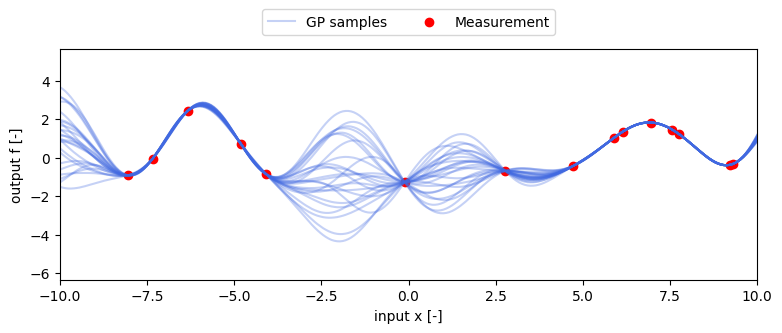

In [114]:

def samplingFromPosterior(Xposterior, Xprior, fprior, lengthScaleSquared, signalVariance):

    Kstarx = kernelMatrixSE(Xprior, Xposterior.T,lengthScaleSquared, signalVariance)
    Kxx = kernelMatrixSE(Xprior, Xprior.T, lengthScaleSquared, signalVariance)
    Kxxinv = np.linalg.inv(Kxx)
    Kstarstar = kernelMatrixSE(Xposterior, Xposterior.T, lengthScaleSquared, signalVariance)

    mean_star = Kstarx@Kxxinv@fprior
    cov_star = Kstarstar - Kstarx @ Kxxinv @ Kstarx.T
    M = cov_star.shape[0]
    L = np.linalg.cholesky(cov_star + np.eye(M)*10**-6)
    N = mean_star.size
    z = np.random.multivariate_normal(np.zeros(N), np.eye(N))
    samples = mean_star.squeeze() + L@z

    return samples.flatten()


lengthScaleSquared = 2
signalVariancePeriod = 2


''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-10, 10, 15).reshape(1, -1)
fData = samplingFromPrior(posData1D, lengthScaleSquared, signalVariancePeriod)

posPred1D = np.linspace(-10, 10, 250).reshape(1, -1)
Nsamples = 25
fPriorSamples = np.zeros((Nsamples, 250))
for samplendx in range(Nsamples):
    fPosteriorSamples[samplendx, :] = samplingFromPosterior(posPred1D, posData1D, fData, lengthScaleSquared, signalVariancePeriod).ravel()

helper.makeGaussianProcessSamplingPlots(posPred1D, fPosteriorSamples, posData1D, fData)


#### Periodic kernel

There are many kernels to choose from and it is up to the engineer to choose the right kernel for the right task. A list of different kernels can be found in the kernel cookbook (https://www.cs.toronto.edu/~duvenaud/cookbook/). A better suited kernel for the previously given data might be a periodic kernel, which can be described with
$$\kappa_{\text{per}}(\mathbf{p},\mathbf{p}') = \sigma^2_{\text{per}}  \text{exp} \left( \frac{\text{sin} \left( \pi \frac{|\mathbf{p} - \mathbf{p}'|}{\text{period}} \right)^2 }{-0.5 l^2} \right)$$


#### Task:

- Given the periodic kernel above, finish the implementation of the functions `kernelPeriodic`, `kernelMatrixPeriodic` and `predictPeriodic`.

- Manually tune the hyper-parameters `lengthScaleSquared`, `signalVariancePeriod`, `noiseVariance`, and  `period`.


#### Analysis:

Elaborate on the quality of the prediction on the left half of the figure and the right half of the figure.
- How well does it predict the latent function? 
- How does it compare to the prediction of the SE kernel

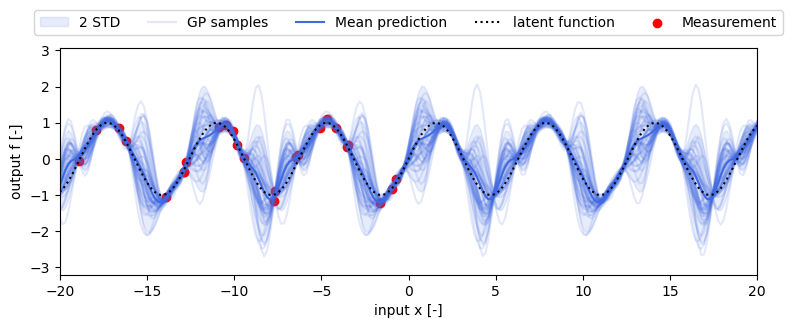

In [ ]:
def kernelPeriodic(x1, x2, lengthScaleSquared, signalVariancePeriod, period):
    k = 
    return k

def kernelMatrixPeriodic(X1, X2, lengthScaleSquared, signalVariancePeriod, period):
    K = ""
    return K

def predictPeriodic(Xstar, X, y, lengthScaleSquared, signalVariancePeriod, period, noiseVariance):
    mean = ""
    cov = ""
    return mean, cov


lengthScaleSquared = .1
signalVariancePeriod = 1
noiseVariance = 0.01
period = 4*np.pi


''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D = helper.generateData(posData1D, 'sin')

f, cov = predictPeriodic(posPred1D, posData1D, yData1D, lengthScaleSquared, signalVariancePeriod, period, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D, posPred1D, f, cov, 'sin')

#### Linear + periodic kernel

Assume the observed data has a linear ascending trend. Using only periodic kernel will fail the prediction as shown below:

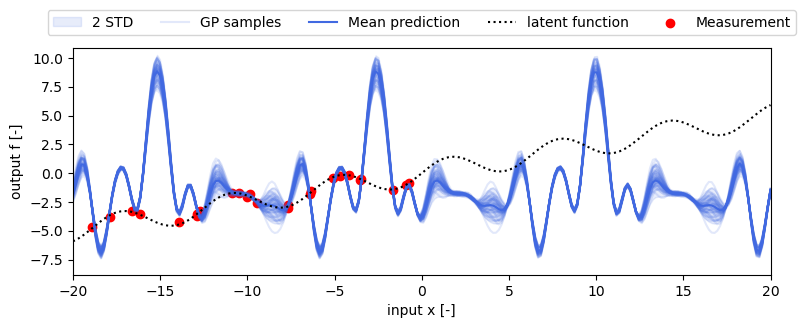

In [ ]:
lengthScaleSquared = .1
signalVariancePeriod = 1
noiseVariance = 0.01
period = 4*np.pi
signalVarianceLin = .25


''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D_v2 = helper.generateData(posData1D, 'linsin', addNoise = True)
f, cov = predictPeriodic(posPred1D, posData1D, yData1D_v2, lengthScaleSquared, signalVariancePeriod, period, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D_v2, posPred1D, f, cov, 'linsin')


In this case, it is also possible to combine kernels, for now we will stick with addition (for all mathematical properties see the kernel cookbook https://www.cs.toronto.edu/~duvenaud/cookbook/). In this example, we will add a periodic kernel and a linear kernel, the latter is defined as



$$
\kappa_{\text{lin}} = \sigma^2_{\text{lin}} \mathbf{p}^{\text{T}} \mathbf{p}'
$$


#### Task:

- Given the periodic kernel above, finish the implementation of the funcitons `kernelLin`, `kernelMatrixLin` and `predictLinPeriodic`.

- Manually tune the hyper-parameters `lengthScaleSquared`, `signalVariancePeriod`, `noiseVariance`, `period` and `signalVarianceLin`.


#### Analysis:

Elaborate on the quality of the prediction on the left half of the figure and the right half of the figure.
- How well does it predict the latent function? 

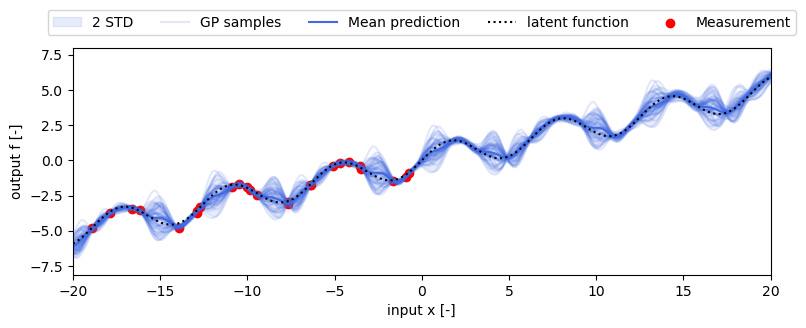

In [ ]:
def kernelLin(x1, x2, sigmaSquaredLin):
    k = ""
    return k

def kernelMatrixLin(X1, X2, signalVarianceLin):
    K =""
    return K

def predictLinPeriodic(Xstar, X, y, lengthScaleSquared, sigmaSquaredF, period, signalVarianceLin, noiseVariance):
    mean = ""
    cov = ""
    return mean, cov


lengthScaleSquared = .1
signalVariancePeriod = 1
noiseVariance = 0.01
period = 4*np.pi
signalVarianceLin = .25



''' Code for plotting: Do not change code below '''
posData1D = np.random.uniform(-20, 0, 25).reshape(1, -1)
posPred1D = np.linspace(-20, 20, 250).reshape(1, -1)
yData1D_v2 = helper.generateData(posData1D, 'linsin', addNoise = True)
f, cov = predictLinPeriodic(posPred1D, posData1D, yData1D_v2, lengthScaleSquared, signalVariancePeriod, period, signalVarianceLin, noiseVariance)
helper.makeGaussianProcessPredictionPlots(posData1D, yData1D_v2, posPred1D, f, cov, 'linsin')


### Optimising the Log Marginal Likelihood

Instead of manually tuning the hyper-parameters, which will be extremely tedious for large data-sets, the hyper-parmaeters can be optimised. This can be done by maximising the marginal log-likelihood with respect to the set of hyper-parameters $\theta$:

$$
\theta_{\text{ML}} = \text{arg} \max_\theta \underbrace{\log p(y|x)}_{\mathcal{L}} 
$$

With

$$
\mathcal{L} = - \frac{1}{2} \operatorname{tr} (\mathbf{y}_{t:T}^\text{T} \mathbf{K}_{\text{y}}  \mathbf{y}_{t:T}) - \frac{1}{2} \log |\mathbf{K}_{\text{y}} |  - \frac{T}{2} \log 2 \pi
$$

where 

$$
\mathbf{K}_{\text{y}} = \mathbf{K}(\mathbf{P}_{1:T}, \mathbf{P}_{1:T}) + \sigma^2_{\text{y}} \mathbf{I}_{T}
$$

Below, you are given the cost function and its gradient in the functions `GP.expLogML` and `GP.expGradLogML` respectively.

#### Task:
Initialize the hyper-parameters to orders of different magnitudes


#### Analysis:
- How can you find out whether the hyper parameter optimum is unique, or whether there maybe other local optima? 
- If there are local optima, find some, and explain what the model is doing in each case. Which fit is best, and why?


#### Note:
If you are interested in the under the hood functions: we re-paramaterise the hyper-parameters into the log space with $s = \text{log}(\theta)$ (not the log in the log marginal likelihood), which ensures non-negatives of the hyper-parameters and generally can be expected to have better perfomance when the initialisation of the hyper-parameters are far off.

Optimized length scale squared: 1.7257179468923811
Optimized sigma squared f: 0.5697659156686892
Optimized noise variance: 0.011641475043182442


<Figure size 900x300 with 0 Axes>

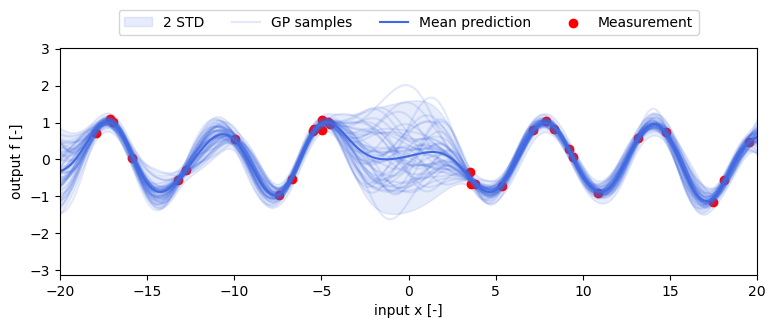

In [ ]:

''' Define initial guess for the hyperparameters
    - lengthScaleSquared
    - signalVarianceSE
    - noiseVariance 
    then transform to log space ''' 

initialLengthScaleSquared = 3
initialSignalVarianceSE = 2
initialNoiseVariance = 1



''' Code for plotting: Do not change code below '''
s0 = np.log([initialLengthScaleSquared, initialSignalVarianceSE, initialNoiseVariance])

posDataOpt = np.hstack((np.random.uniform(-20, -3, 15).reshape(1, -1), np.random.uniform(3, 20, 15).reshape(1, -1)))
posPred = np.linspace(-20, 20, 250).reshape(1, -1)
yDataOpt = helper.generateData(posDataOpt, 'sin')

''' Optimize the hyperparameters using BFGS ''' 
result = opt.minimize(GP.expLogML, s0, jac=GP.expGradLogML, method='BFGS', args=(posDataOpt, yDataOpt))

''' Extract the optimized hyperparameters, transform back from log space ''' 
lengthScaleSquaredOpt = np.exp(result.x[0])
signalVarianceSEOpt = np.exp(result.x[1])
noiseVarianceOpt = np.exp(result.x[2])

print("Optimized length scale squared:", lengthScaleSquaredOpt)
print("Optimized sigma squared f:", signalVarianceSEOpt)
print("Optimized noise variance:", noiseVarianceOpt)

plt.figure(figsize=(9,3), dpi=100)

# f, cov = predictSE(posPred, posDataOpt, yDataOpt, initialLengthScaleSquared, initialSignalVarianceSE, initialNoiseVariance)
f, cov = predictSE(posPred, posDataOpt, yDataOpt, lengthScaleSquaredOpt, signalVarianceSEOpt, noiseVarianceOpt)
helper.makeGaussianProcessPredictionPlots(posDataOpt, yDataOpt, posPred, f, cov, 'none', noiseVarianceOpt)



#### Making a magnetic field plot

Based on what you have learned before, you are able to make your very first magnetic field map using Gaussian processes. Note that the magnetic field you will map consists of the Earth's magnetic field and disturbances induced by ferro-magnetic materials in indoor environments. These two components can be modeled by a constant kernel and a squared exponential kernel respectively. The constant kernel is defined as

$$
\kappa_{\text{con}}(\mathbf{p}, \mathbf{p}') = \sigma^2_{\text{con}} 
$$


#### First load in the data
To start, first load in the data below
All variables you will use are numpy arrays, where
- `magnetometerMeasurements` $\in \mathbb{R}^{3 \times \text{T}}$ is a numpy array containing the magnetometer measurements
- `magnetometerPositions` $\in \mathbb{R}^{3 \times \text{T}}$ is a numpy array containing the true positions of the magnetometer

#### Warning
- Additionally you are provided with a dictionary modelParameters which is used in creating magnetic field maps. DO NOT CHANGE dictionary as this might break the assignment. To create the magnetic field map you DO NOT need this dictionary.
The data is similar to the two previous assignments. Although this time, you may assumes you have access to all the true magnetometer positions.

In [ ]:
''' load in the data'''
(magnetometerMeasurements, 
 magnetometerPositions,
 modelParameters) = helper.initializeGaussianProcessAssignment(groupNumber % 29)

#### Task:

- Implement the functions `kernelCon`, `kernelMatrixCon` and `predictGPmagneticField`.
To begin, you may start with the hyper-parameters
- `lengthScaleSquared` = 0.1**2
- `signalVariancePeriod` = 10**2 
- `noiseVariance` =  0.001
- `signalVarianceCon` = 1**2

Manually tune the hyper-parameters so the magnetic field on the right is similar to the magnetic field on the left. They are approximately in the correct order of magnitude.

#### Note:
The reference map is created by inducing the curl-free assumption of the magnetic field in the Gaussian process model, which leeads to a 3D output of the GP predicitons. As this is beyond the scope of this assignment, you may simplify the problem by first taking the norm of the magnetic field measurements. 

#### Analysis:

Elaborate on the physical interpretation of the hyper-parameters in the context of magnetic field mapping.


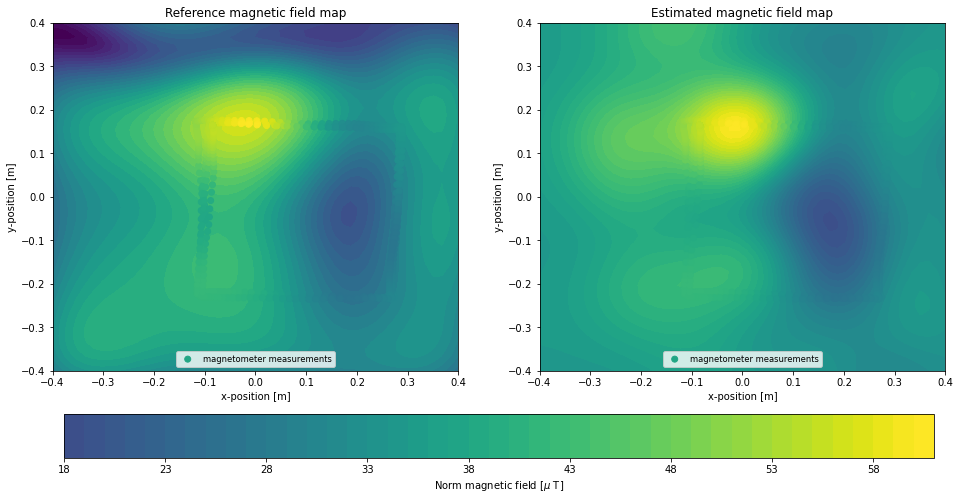

In [ ]:

def kernelCon(x1, x2, signalVarianceCon):
    k = ""
    return k

def kernelMatrixCon(X1, X2, sigmaSquaredCon):
    K = ""
    return K

def predictGPmagneticField(Xstar, X, y, lengthScaleSquared, sigmaSquaredF, noiseVariance, sigmaSquaredCon):
    mean = ""
    cov = ""
    return mean, cov


magnetomerNorm = ""

lengthScaleSquared = 0.1**2
signalVariancePeriod = 1**2 
noiseVariance =  0.001
signalVarianceCon = 10**2

''' Code for plotting: Do not change code below '''
posPred = linAlg.gridpointsHyperCube(25, 2, 3, np.array([[-0.4, 0.4],[-0.4, 0.4]]))
f, cov = predictGPmagneticField(posPred, magnetometerPositions, magnetomerNorm, lengthScaleSquared, signalVariancePeriod, noiseVariance, signalVarianceCon)
helper.makeGaussianProcessMagneticFieldMapPlots(magnetometerPositions, posPred, f, cov, magnetomerNorm, modelParameters)

#### Feedback:
This is the first year we are teaching this course. Your feedback will be invaluable in improving it for the coming years. Please let us know in this markdown any comments, suggestions or errors you have encountered in the last three assignments.  
